In [1]:
import tensorflow as tf

tf.enable_eager_execution()

/Users/gmontes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# Variables.
# Tensors in TensorFlow are immutable stateless objects. 
# Machine learning models, however, need to have changing state: 
# as your model trains, the same code to compute predictions should behave differently over time 
# (hopefully with a lower loss!). To represent this state which needs to change over the course of your computation, 
# you can choose to rely on the fact that Python is a stateful programming language.
# Using python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original value of x.
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In [6]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

# Re-assign the value
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow operation like tf.square() and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

# Fitting a linear model.
Computations using Variables are automatically traced when computing gradients. 
For Variables representing embeddings TensorFlow will do sparse updates by default, 
which are more computation and memory efficient.
Using Variables is also a way to quickly let a reader of your code know that this piece of state is mutable.

Let's now put the few concepts we have so far ---Tensor, GradientTape, Variable --- to build and train a simple model. This typically involves a few steps:

Define the model.
Define a loss function.
Obtain training data.
Run through the training data and use an "optimizer" to adjust the variables to fit the data.
In this tutorial, we'll walk through a trivial example of a simple linear model: f(x) = x * W + b, which has two variables - W and b. Furthermore, we'll synthesize data such that a well trained model would have W = 3.0 and b = 2.0.

In [8]:
# Define the model.
# Let's define a simple class to encapsulate the variables and the computation.
class Model(object):
  def __init__(self):
    # Initialize variable to (5.0, 0.0)
    # In practice, these should be initialized to random values.
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)
    
  def __call__(self, x):
    return self.W * x + self.b
  
model = Model()

assert model(3.0).numpy() == 15.0

In [9]:
# Define a loss function.
# A loss function measures how well the output of a model for a given input matches the desired output. 
# Let's use the standard L2 loss.
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

In [14]:
# Obtain training data.
# Let's synthesize the training data with some noise.
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random_normal(shape=[NUM_EXAMPLES])
noise   = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

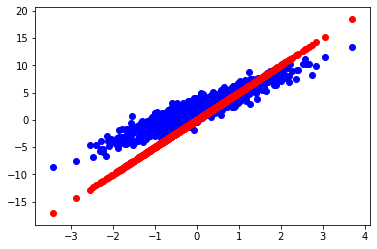

Current loss: 
8.703793


In [15]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

# Define a training loop
We now have our network and our training data. Let's train it, i.e., use the training data to update the model's variables (W and b) so that the loss goes down using gradient descent. There are many variants of the gradient descent scheme that are captured in tf.train.Optimizer implementations. We'd highly recommend using those implementations, but in the spirit of building from first principles, in this particular example we will implement the basic math ourselves.

Epoch  0: W=5.00 b=0.00, loss=8.70379
Epoch  1: W=4.62 b=0.39, loss=6.01386
Epoch  2: W=4.31 b=0.70, loss=4.27097
Epoch  3: W=4.06 b=0.96, loss=3.14169
Epoch  4: W=3.86 b=1.16, loss=2.40997
Epoch  5: W=3.70 b=1.32, loss=1.93585
Epoch  6: W=3.57 b=1.45, loss=1.62865
Epoch  7: W=3.47 b=1.56, loss=1.42959
Epoch  8: W=3.38 b=1.64, loss=1.30060
Epoch  9: W=3.31 b=1.71, loss=1.21702


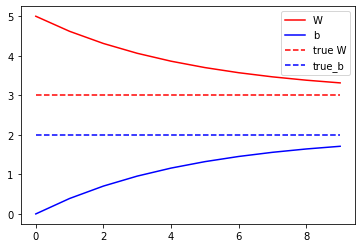

In [17]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()